In [ ]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG19,ResNet50, EfficientNetB0
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

### Loading dataset

In [3]:
# number of class
n_class = 5

# path to kaggle dataset
root_path = "./PreprocessedAll5/"

# list of folders
folder_list = os.listdir(root_path)
image_path_list = []
label_list = []

# for each folder, get the image path and labels
for folder in folder_list:
    for label in range(n_class):
        
        # get all the images path inside the current folder
        image_list = os.listdir(f"{root_path}{folder}/{label}")
        # add to the image path list
        image_path_list += [ f"{root_path}{folder}/{label}/"+ path for path in image_list]
        
        # add labels to the label list
        label_list += [label] * len(image_list)

# convert to dataframe
df_train_kaggle = pd.DataFrame({"filepath" : image_path_list, "label": label_list})
print(df_train_kaggle.shape)

(9796, 2)


In [4]:
df_train_kaggle.head()

,filepath,label
0,./PreprocessedAll5/auto_test/0/9003175_1.png,0
1,./PreprocessedAll5/auto_test/0/9003175_2.png,0
2,./PreprocessedAll5/auto_test/0/9003316_2.png,0
3,./PreprocessedAll5/auto_test/0/9003815_1.png,0
4,./PreprocessedAll5/auto_test/0/9003815_2.png,0


Text(0, 0.5, 'count')

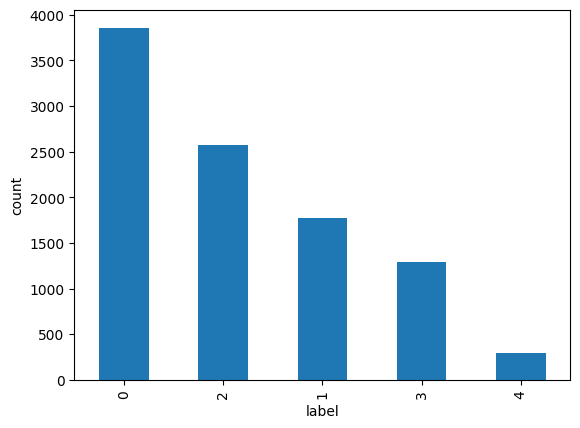

In [4]:
df_train_kaggle.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In the above plot, we can see class imbalance in the data.

In [6]:
# train data generator object
train_aug = ImageDataGenerator(rescale=1./255)

# validation data generator object
valid_aug = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_aug.flow_from_dataframe(
dataframe=df_train_kaggle,
directory=None,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 9796 validated image filenames.


### Preparing validation and test data

In [12]:
compi_root_path= "./PreprocessedValidation/"
df_val_compi = pd.read_csv(compi_root_path + "Train.csv")

# add absolute path to the image names
df_val_compi["filename"] = df_val_compi.filename.apply(lambda x: compi_root_path+"Val Data/" + x)
df_val_compi.head()

,filename,label
0,./PreprocessedValidation/Val Data/Image_1.jpg,0
1,./PreprocessedValidation/Val Data/Image_2.jpg,1
2,./PreprocessedValidation/Val Data/Image_3.jpg,0
3,./PreprocessedValidation/Val Data/Image_4.jpg,1
4,./PreprocessedValidation/Val Data/Image_5.jpg,2


Text(0, 0.5, 'count')

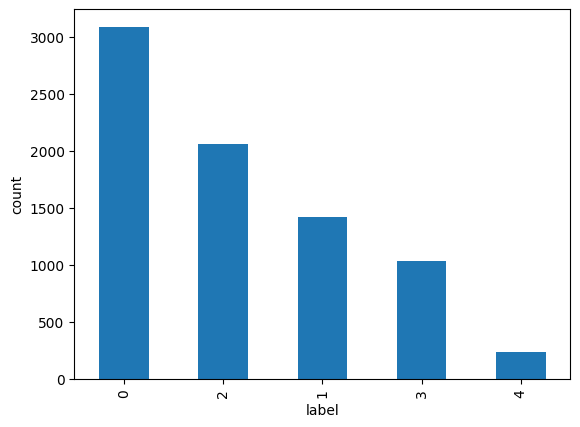

In [13]:
df_val_compi.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [14]:
# Step 1: Split validation data into x_val and x_test
x_val, x_test = train_test_split(df_val_compi, test_size=0.35, random_state=42)

# Create separate generators for x_val and x_test
val_generator = valid_aug.flow_from_dataframe(
    dataframe=x_val,
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=False,  # No need to shuffle for evaluation
    class_mode="raw",
    target_size=(224, 224)
)

test_generator = valid_aug.flow_from_dataframe(
    dataframe=x_test,
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=False,  # No need to shuffle for evaluation
    class_mode="raw",
    target_size=(224, 224)
)

Found 5088 validated image filenames.
Found 2740 validated image filenames.


### Baseline Model - VGG19 with basic transfer learning

In [15]:
# checking if CUDA is working fine

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU acceleration enabled!")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")

✅ GPU acceleration enabled!


In [18]:
# ✅ Enable GPU memory growth for TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU acceleration enabled!")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")
    
# Load pre-trained VGG19 model with ImageNet weights
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# Combine the base model with custom classification head
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

✅ GPU acceleration enabled!
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (N

In [19]:
# training the model

hist=model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/10
307/307 [==============================] - 70s 227ms/step - loss: 1.3993 - accuracy: 0.3935 - val_loss: 1.3758 - val_accuracy: 0.4051
Epoch 2/10
307/307 [==============================] - 46s 151ms/step - loss: 1.3441 - accuracy: 0.4328 - val_loss: 1.3083 - val_accuracy: 0.4202
Epoch 3/10
307/307 [==============================] - 50s 163ms/step - loss: 1.2964 - accuracy: 0.4486 - val_loss: 1.2701 - val_accuracy: 0.4536
Epoch 4/10
307/307 [==============================] - 48s 157ms/step - loss: 1.2619 - accuracy: 0.4562 - val_loss: 1.2325 - val_accuracy: 0.4768
Epoch 5/10
307/307 [==============================] - 47s 155ms/step - loss: 1.2378 - accuracy: 0.4661 - val_loss: 1.2401 - val_accuracy: 0.4733
Epoch 6/10
307/307 [==============================] - 50s 162ms/step - loss: 1.2241 - accuracy: 0.4723 - val_loss: 1.2039 - val_accuracy: 0.4778
Epoch 7/10
307/307 [==============================] - 49s 159ms/step - loss: 1.2094 - accuracy: 0.4817 - val_loss: 1.2153 - val_ac

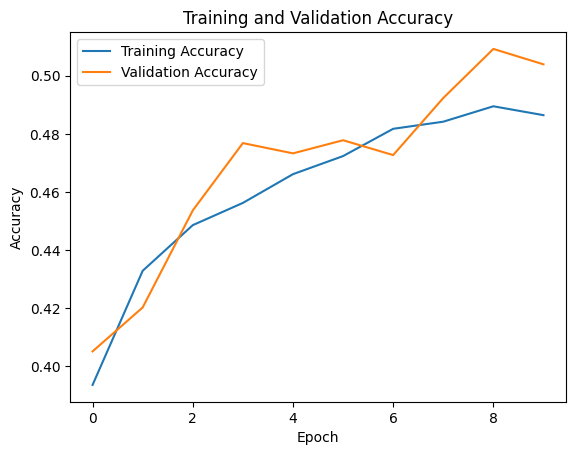

In [20]:
# Plot training and validation accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

86/86 [==============================] - 19s 220ms/step
Confusion Matrix:
[[982   1 102   9   3]
 [403   1  79   7   2]
 [423   2 232  71   5]
 [127   0  91  91  27]
 [ 10   0  12  18  42]]


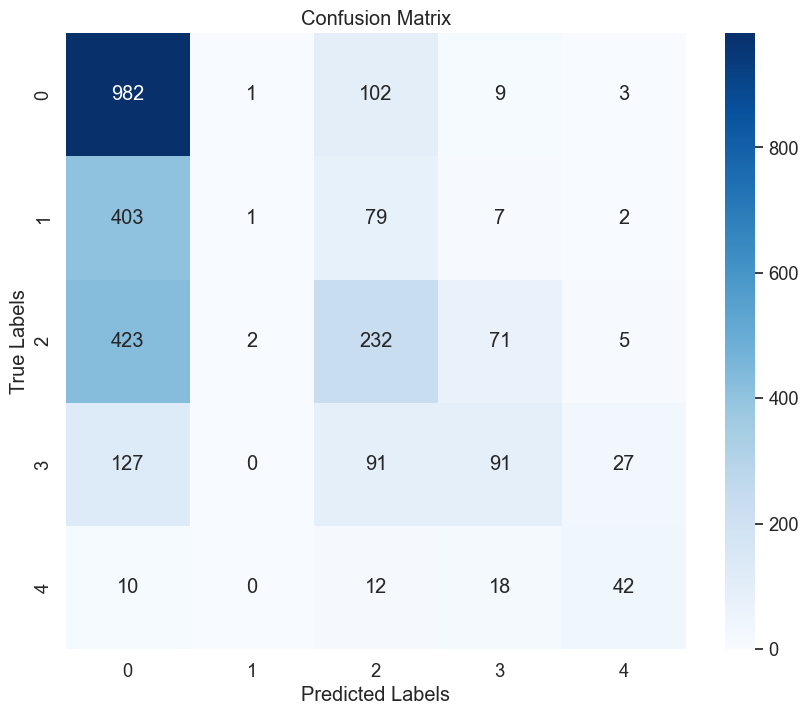

In [21]:
# Step 2: Use your model to predict labels for x_test
predictions = model.predict(test_generator)

# Step 3: Evaluate the predictions using a confusion matrix
true_labels = x_test["label"].values
predicted_labels = predictions.argmax(axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
classes = unique_labels(true_labels, predicted_labels)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.90      0.65      1097
           1       0.25      0.00      0.00       492
           2       0.45      0.32      0.37       733
           3       0.46      0.27      0.34       336
           4       0.53      0.51      0.52        82

    accuracy                           0.49      2740
   macro avg       0.44      0.40      0.38      2740
weighted avg       0.44      0.49      0.42      2740



This classification report reveals performance difficulties in classifying classes 1,2 and 3. The significant class imbalance underscores the 
importance of the F1-score, which offers a more robust evaluation metric than accuracy 
alone. Epoch 8 likely represents the optimal training point; further iterations could 
lead to overfitting and reduced generalization performance. This pattern is reinforced by the 
confusion matrix, which emphasizes misclassifications within classes 1, 2, and 3. 
To enhance results, we'll be exploring alternative feature engineering techniques, model 
architectures, or hyperparameter optimization.

In [ ]:
# Saving the vgg19 model with the best checkpoint



# Corrected checkpoint path
checkpoint_path = "vgg19_best.weights.h5"  # Ensure it ends with `.weights.h5`
checkpoint_dir = os.path.dirname(checkpoint_path)

# Define callbacks
my_callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_acc',  # Ensure 'val_acc' exists in model metrics
                    verbose=1,
                    save_weights_only=True,
                    save_best_only=True,
                    mode="max"),
    EarlyStopping(monitor='val_loss',
                  patience=5,
                  verbose=1),
    ReduceLROnPlateau(monitor='val_loss',
                      patience=5,
                      verbose=1)
]

### VGG19 with Imagenet weights and Convolution Layers

In [ ]:
# Load pre-trained VGG19 model with ImageNet weights
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Conv2D(filters=1024, kernel_size=3, padding="same", activation="relu")(base_model.output)
x = BatchNormalization()(x)

x = Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

# Global pooling layer
GAP = GlobalAveragePooling2D()(x)

# Output layer
n_classes = 5  # Number of classes in your output
pred = Dense(n_classes, activation='softmax')(GAP)

# Define the model
vgg19_model = Model(inputs=base_model.input, outputs=pred)

# Compile the model
vgg19_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

vgg19_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(df_train_kaggle.label.values),
                                                 y= df_train_kaggle.label.values)
class_weights = dict(enumerate(class_weights))

# Train the model

history = vgg19_model.fit(
    train_generator,
    epochs=22,
    validation_data=val_generator,
    callbacks=[my_callbacks],
    class_weight=class_weights
)

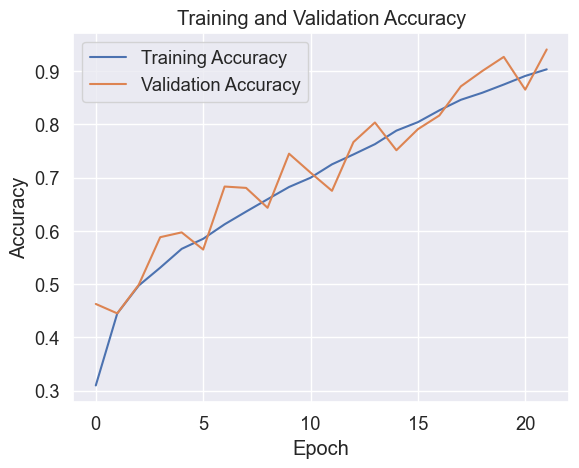

In [29]:
# Plot training and validation accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

86/86 [==============================] - 10s 114ms/step
Confusion Matrix:


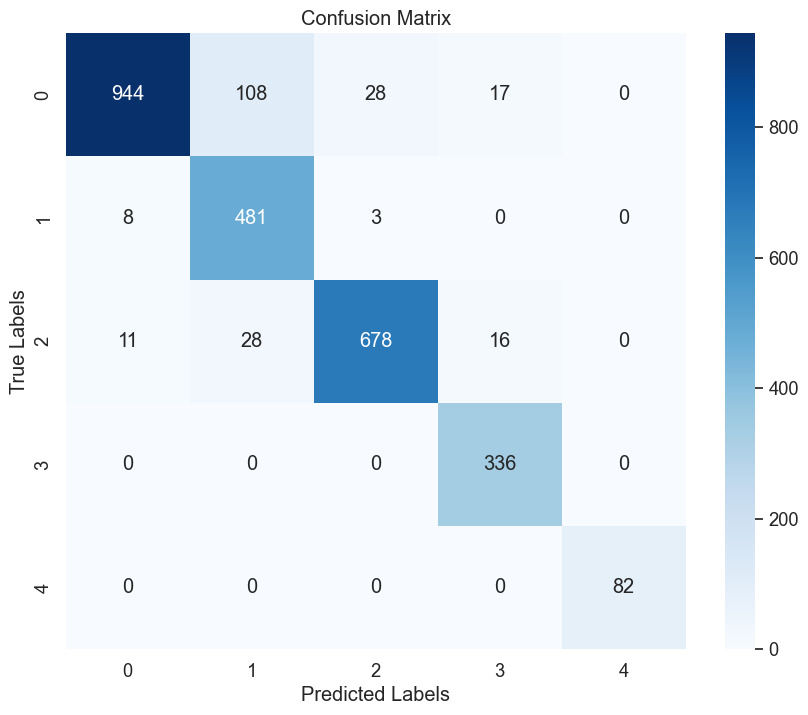

In [30]:
vgg19_model.load_weights(checkpoint_path)

# Step 2: Use your model to predict labels for x_test
predictions = vgg19_model.predict(test_generator)

# Step 3: Evaluate the predictions using a confusion matrix
true_labels = x_test["label"].values
predicted_labels = predictions.argmax(axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
classes = unique_labels(true_labels, predicted_labels)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      1097
           1       0.78      0.98      0.87       492
           2       0.96      0.92      0.94       733
           3       0.91      1.00      0.95       336
           4       1.00      1.00      1.00        82

    accuracy                           0.92      2740
   macro avg       0.93      0.95      0.94      2740
weighted avg       0.93      0.92      0.92      2740



In [32]:
vgg19_model.save('vgg19_model.h5')

### XCeption Model

In [ ]:
base_model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Conv2D(filters=1024, kernel_size=3, padding="same", activation="relu")(base_model.output)
x = BatchNormalization()(x)

x = Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

n_classes = 5  # number of classes
x = Conv2D(filters=n_classes, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

# Global pooling layer
GAP = GlobalAveragePooling2D()(x)

# Output layer
pred = Dense(n_classes, activation='softmax')(GAP)

# Define the model
xception_model = Model(inputs=base_model.input, outputs=pred)

# Compile the model
xception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [14]:
# compile
xception_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "xception_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=5,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=5,
                                verbose=1)
]

In [17]:
# train the model
history1 = xception_model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
xception_model.load_weights(checkpoint_path)

Epoch 1/20
307/307 [==============================] - ETA: 0s - loss: 1.4040 - acc: 0.2336
Epoch 1: val_acc improved from -inf to 0.27791, saving model to xception_best.ckpt
307/307 [==============================] - 234s 725ms/step - loss: 1.4040 - acc: 0.2336 - val_loss: 1.5076 - val_acc: 0.2779 - lr: 1.0000e-05
Epoch 2/20
307/307 [==============================] - ETA: 0s - loss: 1.2346 - acc: 0.3290
Epoch 2: val_acc improved from 0.27791 to 0.37618, saving model to xception_best.ckpt
307/307 [==============================] - 68s 222ms/step - loss: 1.2346 - acc: 0.3290 - val_loss: 1.3586 - val_acc: 0.3762 - lr: 1.0000e-05
Epoch 3/20
307/307 [==============================] - ETA: 0s - loss: 1.1315 - acc: 0.3877
Epoch 3: val_acc improved from 0.37618 to 0.41509, saving model to xception_best.ckpt
307/307 [==============================] - 66s 215ms/step - loss: 1.1315 - acc: 0.3877 - val_loss: 1.3040 - val_acc: 0.4151 - lr: 1.0000e-05
Epoch 4/20
307/307 [============================

To improve upon the VGG19 model, we've incorporated strategic advancements into the 
Xception model.  Firstly, it capitalizes on the power of depthwise separable convolutions. 
This technique significantly decreases computational cost and parameter count compared to 
traditional convolutions in the VGG19. This reduction in complexity helps mitigate 
overfitting and accelerate training. Moreover, we leverage a refined transfer learning 
approach by loading pre-trained Xception weights from ImageNet. This enables us to harness 
robust, generalized features while fine-tuning for our specific task. Additionally, we replaced 
the original classification head with a custom one. This custom head includes convolutional 
layers with batch normalization, tailored for highly discriminative feature learning from our 
dataset.  This customization promotes effective extraction of our image data's unique patterns, 
boosting classification performance. 

Furthermore, we introduce custom weights calculated using the 
class_weight.compute_class_weight function from the sklearn.utils module. These weights 
address potential class imbalances within our dataset. By assigning higher weights to 
minority classes, we ensure that the model doesn't overlook them during the training process. 
This focus on balanced class representation helps the model generalize better to unseen data.

Regarding optimization, we use the Adam optimizer with a carefully chosen learning rate 
(0.00001) and weight decay (0.0001).  The low learning rate aids in fine-tuning the pre
trained model, and weight decay encourages generalization by favoring simpler solutions. For 
our multi-class classification problem with integer-based class labels, the 
'sparse_categorical_crossentropy' loss function was the clear choice. To monitor our progress, we tracked the 'accuracy' metric, which measures the percentage of correctly classified 
examples.

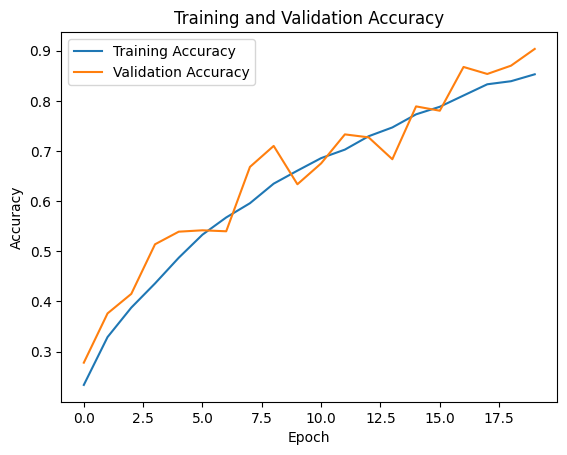

In [ ]:
# Plot training and validation accuracy

plt.plot(history1.history['acc'], label='Training Accuracy')
plt.plot(history1.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

86/86 [==============================] - 21s 239ms/step
Confusion Matrix:


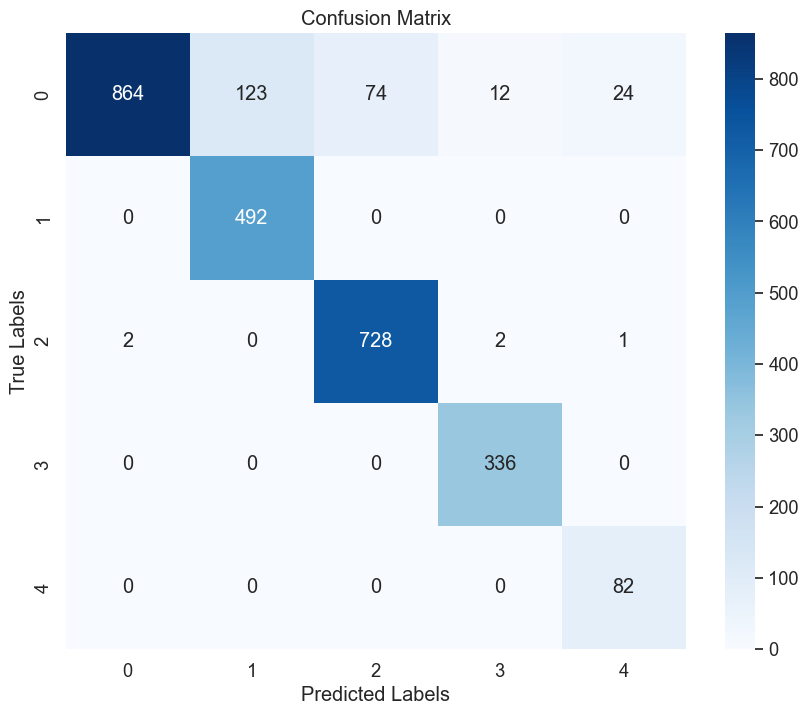

In [20]:
predictions = xception_model.predict(test_generator)

true_labels = x_test["label"].values
predicted_labels = predictions.argmax(axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
classes = unique_labels(true_labels, predicted_labels)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
report = classification_report(true_labels, predicted_labels)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      1097
           1       0.80      1.00      0.89       492
           2       0.91      0.99      0.95       733
           3       0.96      1.00      0.98       336
           4       0.77      1.00      0.87        82

    accuracy                           0.91      2740
   macro avg       0.89      0.96      0.91      2740
weighted avg       0.93      0.91      0.91      2740



### Comparison of the models 

we compared the performance of VGG19 and Xception for multi-class image classification. VGG19 achieved 92% accuracy, outperforming Xception's 91%, with higher precision and F1-scores across most classes. However, Xception demonstrated superior recall (96%), indicating better detection of true positives but at the cost of lower precision, particularly in Class 4 (precision: 0.77). Architecturally, Xception is more computationally efficient, leveraging depthwise separable convolutions, leading to slightly faster training times. VGG19, with its deeper custom head, showed better generalization across all classes. If precision and balanced accuracy are priorities, VGG19 is preferable, whereas Xception may be more suitable when recall is critical. Fine-tuning both models further and employing ensemble techniques could enhance performance.

In [22]:
xception_model.save('xception_model.h5')

To further enchance this project, we will use ResNet50 and EfficientNet to compare with XCeption and VGG19 models

### ResNet50 

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train_kaggle.label.values),  # Unique class labels
    y=df_train_kaggle.label.values  # All training labels
)

# Convert to dictionary format for Keras
class_weights = dict(enumerate(class_weights))

In [28]:
# Load pre-trained ResNet50 model with ImageNet weights
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model

for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom classification head

x = Conv2D(filters=1024, kernel_size=3, padding="same", activation="relu")(base_model.output)
x = BatchNormalization()(x)
x = Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

# Output layer

n_classes = 5  # Number of classes in the output
output_layer = Dense(n_classes, activation='softmax')(x)

# defining resnet model

resnet_model = Model(inputs=base_model.input, 
                     outputs=output_layer)

resnet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
                    metrics=["acc"],
                    loss= tf.keras.losses.sparse_categorical_crossentropy)

resnet_model.summary()


# Define the checkpoint path
resnet_checkpoint_path = "best_resnet_model.h5"

# Callback to save the best model
checkpoint_resnet = ModelCheckpoint(resnet_checkpoint_path, 
                                    monitor='val_loss',  # Save based on lowest validation loss
                                    save_best_only=True, 
                                    mode='min', 
                                    verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_resnet = resnet_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint_resnet, early_stopping],  # Apply callbacks
 
    class_weight=class_weights
)

# Load best saved weights
resnet_model.load_weights(resnet_checkpoint_path)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

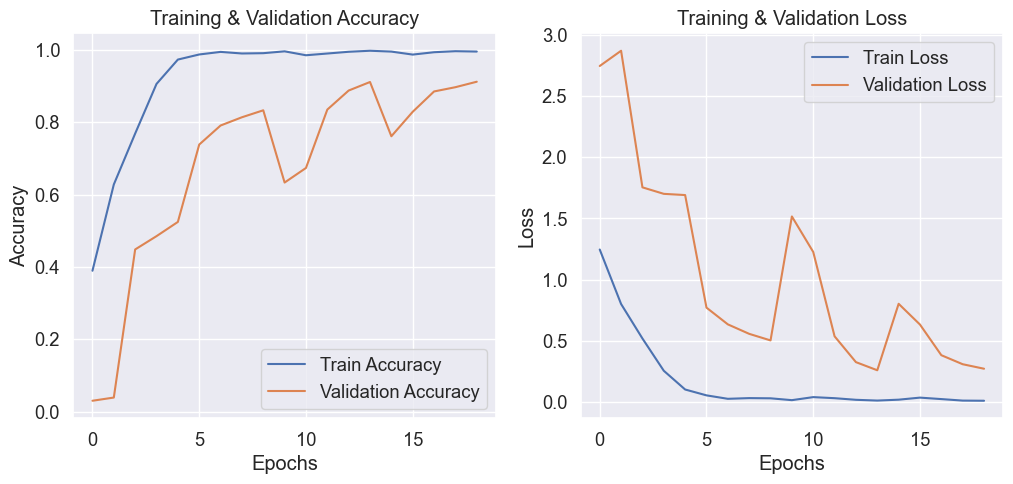

In [29]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'], label='Train Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    
    plt.show()

plot_training_history(history_resnet)

86/86 [==============================] - 7s 73ms/step
Confusion Matrix:


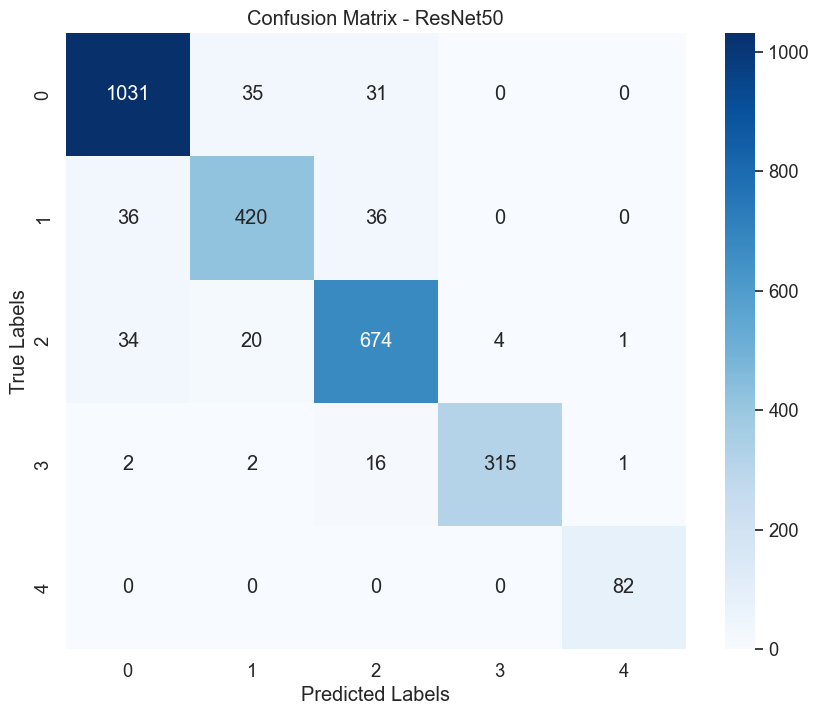

In [32]:
predictions = resnet_model.predict(test_generator)

true_labels = x_test["label"].values
predicted_labels = predictions.argmax(axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
classes = unique_labels(true_labels, predicted_labels)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - ResNet50')
plt.show()

In [33]:
report = classification_report(true_labels, predicted_labels)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1097
           1       0.88      0.85      0.87       492
           2       0.89      0.92      0.90       733
           3       0.99      0.94      0.96       336
           4       0.98      1.00      0.99        82

    accuracy                           0.92      2740
   macro avg       0.93      0.93      0.93      2740
weighted avg       0.92      0.92      0.92      2740



### Conclusion


This project successfully developed an automated system for classifying knee osteoarthritis severity 
using X-ray images. We explored the effectiveness of two powerful deep learning models: VGG19 
and Xception. Both models were enhanced with customized transfer learning strategies, class weights 
to address imbalance, and tailored classification heads.

Careful analysis of the classification reports and confusion matrices indicates that both models 
achieved promising results. The Xception model demonstrated a slight edge in performance, likely 
due to its computationally efficient depth wise separable convolutions. Its reduced complexity 
contributed to faster training and potentially better resistance to overfitting.

This work highlights the potential of deep learning models for aiding in the diagnosis of knee 
osteoarthritis. The developed system could assist medical professionals by providing them with a 
reliable and automated tool for assessing X-ray images.